# Model: Logistic Regression

## Imports and Settings

In [1]:
# Helper libraries
import warnings
from itertools import combinations

# Scientific libraries
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import recall_score

# Local Imports
from churn_detection.utils import get_feature_names
from churn_detection.data import load_data
from churn_detection.visualization import plot_confusion_table, plot_pie
from churn_detection.preprocessing import preprocess_data, split_data
from churn_detection.evaluation import display_clf_report, validate_model_with_cv
from churn_detection.features import (ColumnPreprocessor, 
                                      Transformation, 
                                      InteractionStrengthExtractor,
                                      FeatureConcatenator, 
                                      RareCategoryEncoder, 
                                      engineer_features, 
                                      create_pipe)


%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Various settings
warnings.filterwarnings("ignore")
np.set_printoptions(precision=4)
sns.set_theme()
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_colwidth", 40)
pd.set_option("display.precision", 4)
pd.set_option("display.max_columns", None)

## Loading and Preparing Data

In [2]:
churn = load_data()

In [3]:
preprocessed_data = preprocess_data(churn)
numeric_variables, categorical_variables = get_feature_names(preprocessed_data)

## Data Modeling

### Feature Tweaking

We will explore category concatenation strategy, and the way to handle its issues with rare category encoding and feature selection.

In [12]:
extractor = InteractionStrengthExtractor("partner", "paymentmethod", ordinal_encode=True)
extractor.fit(preprocessed_data)

new_preprocessed_data = extractor.transform(preprocessed_data)
strength_feature = extractor.get_strength_col_name()

discrete_vars_pairs = list(combinations(categorical_variables, 2))
concat_transformer = FeatureConcatenator(feature_pairs=discrete_vars_pairs)
concat_preprocessed_data = concat_transformer.transform(new_preprocessed_data)

multimodal_set = numeric_variables[:-1] + [strength_feature]
skewed_set = ["totalcharges"] 
discrete_set = categorical_variables + concat_transformer.get_new_feature_names()

MULTIMODAL_FEATURES = {
    "name": "multimod", "variables": multimodal_set,
    "steps": [("stdscaler", StandardScaler())],
}

DISCRETE_FEATURES = {
    "name": "discrete", "variables": discrete_set,
    "steps": [
        ("rarecat", RareCategoryEncoder(tol=0.2)),
        ("catencoder", OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore"))
    ],
}

SKEWED_FEATURES = {
    "name": "skewed", "variables": skewed_set,
    "steps": [("robustscaler", RobustScaler(quantile_range=(40, 60)))],
}

pipeline = ColumnPreprocessor()
pipeline.add_transformation(
    Transformation(**MULTIMODAL_FEATURES)
)
pipeline.add_transformation(
    Transformation(**SKEWED_FEATURES)
)
pipeline.add_transformation(
    Transformation(**DISCRETE_FEATURES)
)

prep_train, prep_test = train_test_split(
        concat_preprocessed_data, 
        test_size=0.2, 
        random_state=1
)

for k in range(224, 257):
    reduce_prep_pipe = Pipeline(steps=[
        ('processor', pipeline.create_preprocessor()),
        ('reducer', SelectKBest(k=k, score_func=f_classif)),     
    ])
    
    lr_pipe = Pipeline(steps=[
        ('transformer', reduce_prep_pipe),       
        ('estimator', LogisticRegression(random_state=0))
    ])
    
    X_train, y_train = split_data(prep_train)
    lr_pipe.fit(X_train, y_train)
    y_pred = lr_pipe.predict(X_train)
    score = recall_score(y_pred, y_train, pos_label=1, average="binary")

    metric = "roc_auc"
    mean, var = validate_model_with_cv(lr_pipe, train_data=(X_train, y_train), metric=metric)
    if mean > 0.832 and var < 0.016:
        print(f"Evaluate with {k} features:")
        print(f"Recall: {score}")
        print(f"Cross Val {str.upper(metric)} score with default threshold: Mean = {mean:.4f}, Var = {var:.4f}")
        print("-----------------------------------------------------------------------------------")

Evaluate with 226 features:
Recall: 0.6759776536312849
Cross Val ROC_AUC score with default threshold: Mean = 0.8322, Var = 0.0159
-----------------------------------------------------------------------------------
Evaluate with 228 features:
Recall: 0.6794564348521183
Cross Val ROC_AUC score with default threshold: Mean = 0.8321, Var = 0.0160
-----------------------------------------------------------------------------------


### Model Evaluation

#### Final Training Pipeline

In [13]:
reduce_prep_pipe = Pipeline(steps=[
    ('processor', pipeline.create_preprocessor()),
    ('reducer', SelectKBest(k=226, score_func=f_classif)),     
])
    
lr_pipe = Pipeline(steps=[
    ('transformer', reduce_prep_pipe),       
    ('estimator', LogisticRegression(random_state=0))
])
lr_pipe.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 Pipeline(steps=[('processor',
                                  ColumnTransformer(transformers=[('multimod',
                                                                   Pipeline(steps=[('stdscaler',
                                                                                    StandardScaler())]),
                                                                   ['tenure',
                                                                    'monthlycharges',
                                                                    'partner_paymentmethod_strength']),
                                                                  ('skewed',
                                                                   Pipeline(steps=[('robustscaler',
                                                                                    RobustScaler(quantile_range=(40,
                                                                                                                 60)))]),
                                                                   ['totalcharges']),
                                                                  ('discrete',
                                                                   Pipeline(steps=[('rarec...
                                                                    'gender_internetservice_concat',
                                                                    'gender_onlinesecurity_concat',
                                                                    'gender_onlinebackup_concat',
                                                                    'gender_deviceprotection_concat',
                                                                    'gender_techsupport_concat',
                                                                    'gender_streamingtv_concat',
                                                                    'gender_streamingmovies_concat',
                                                                    'gender_contract_concat',
                                                                    'gender_paperlessbilling_concat', ...])])),
                                 ('reducer', SelectKBest(k=226))])),
                ('estimator', LogisticRegression(random_state=0))])

#### Final Score on Test Data

What interests us here for now is the % of churning users we can detect with our classifier and its default parameters.<br>
Thus essentially recall score on positive class and the deduced remaining % we fail to reach.

In [14]:
X_test, y_test = split_data(prep_test)

In [15]:
test_predictions = lr_pipe.predict(X_test)
display_clf_report(test_predictions, y_test)

              precision    recall  f1-score   support

           0       0.87      0.85      0.86      1061
           1       0.57      0.63      0.60       348

    accuracy                           0.79      1409
   macro avg       0.72      0.74      0.73      1409
weighted avg       0.80      0.79      0.80      1409



#### Confusion Table on Test Set

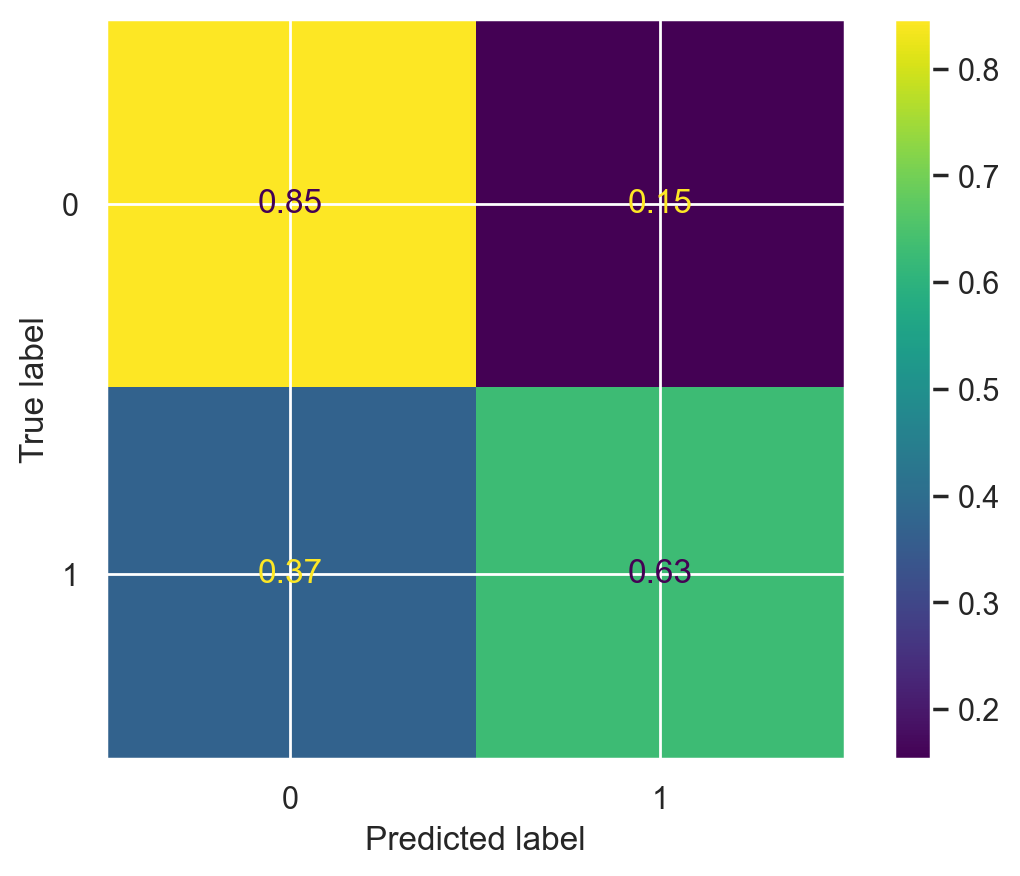

In [16]:
# Test Errors
plot_confusion_table(y_test, test_predictions)

This classifier's skill is better in peformance than previous ones for reaching churned customers.